<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/RAG-literatureReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative AI in Research: using Large Language Models (LLMs) to enhance and streamline the academic literature review process.

leverage RAG Techniques for summarizing papers, identifying connections across papers (authors, references, methods), uncovering key themes in them, and Constructing a knowledge graph to visualize and interpret findings.

Download 5 papers (related to diffusion model) and convert them to 5 .txt files in a directory named "data". Use these .txt files as input papers and evaluate if the RAG technique is giving good results.

In [1]:
!pip install pymupdf requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 15.7 MB/s eta 0:00:00


### download any 2 papers of diffusion model and convert their pdf to .txt files

In [2]:
!rm -r data

rm: cannot remove 'data': No such file or directory


In [3]:
import os
import requests
import fitz  # PyMuPDF

# Sample arXiv paper IDs related to diffusion models
arxiv_ids = [
    "2006.11239",  # Denoising Diffusion Probabilistic Models
    "2105.05233",  # Improved Denoising Diffusion Probabilistic Models
]

def download_pdf(arxiv_id, output_folder):
    url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"
    pdf_path = os.path.join(output_folder, f"{arxiv_id}.pdf")
    response = requests.get(url)
    with open(pdf_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded {arxiv_id}")
    return pdf_path

def pdf_to_text(pdf_path, txt_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Converted to text: {txt_path}")

def main():
    data_dir = "data"
    os.makedirs(data_dir, exist_ok=True)

    for arxiv_id in arxiv_ids:
        pdf_path = download_pdf(arxiv_id, data_dir)
        txt_path = os.path.join(data_dir, f"{arxiv_id}.txt")
        pdf_to_text(pdf_path, txt_path)

if __name__ == "__main__":
    main()


Downloaded 2006.11239
Converted to text: data/2006.11239.txt
Downloaded 2105.05233
Converted to text: data/2105.05233.txt


In [4]:
!rm data/*.pdf

In [5]:
# Install dependencies
!pip install langchain langchain_community faiss-cpu sentence-transformers transformers networkx matplotlib spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Device set to use cpu



🔍 Processing Document: data/2006.11239.txt

🔍 Analyzing Chunk...

🔍 Summary:
We present high quality image synthesis results using diffusion probabilistic models, a class of latent variable models inspired by considerations from nonequilibrium.

🔍 Connections:
We present high quality image synthesis results using diffusion probabilistic models

🔍 Themes:
Denoising Diffusion Probabilistic Models

🔍 Analyzing Chunk...

🔍 Summary:
The results obtained by training on a weighted variational bound designed according to a novel connection between diffusion probabilistic models and denoising score matching with Langevin dynamics, and our models nat- urally admit a progressive lossy decompression scheme that can be interpreted as a

🔍 Connections:
connection

🔍 Themes:
thermodynamics

🔍 Analyzing Chunk...

🔍 Summary:
We obtain an Inception score of 9.46 and a state-of-the-art FID score of 3.17 on 256x256 LSUN.

🔍 Connections:
We obtain an Inception score of 9.46 and a state-of-the-art FID scor

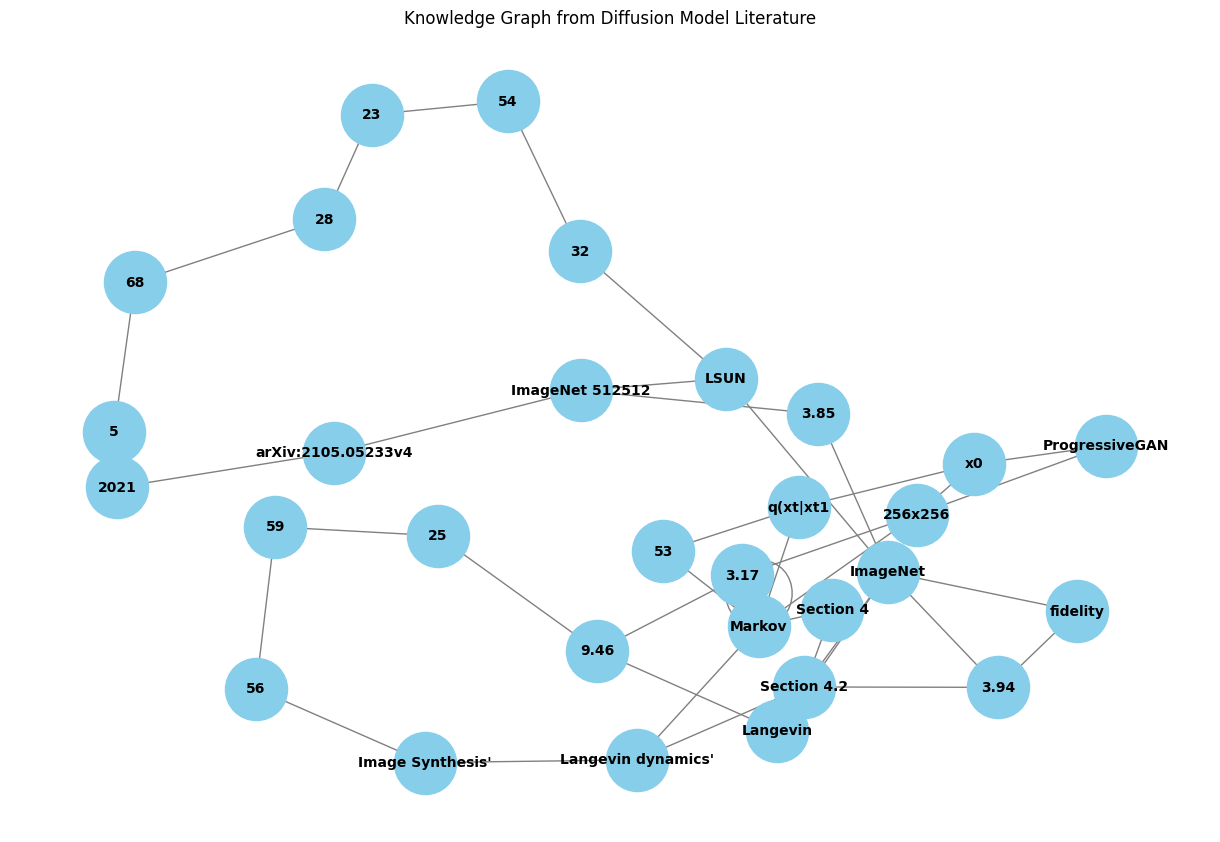


Final Summary:
['We present high quality image synthesis results using diffusion probabilistic models, a class of latent variable models inspired by considerations from nonequilibrium.', 'The results obtained by training on a weighted variational bound designed according to a novel connection between diffusion probabilistic models and denoising score matching with Langevin dynamics, and our models nat- urally admit a progressive lossy decompression scheme that can be interpreted as a', 'We obtain an Inception score of 9.46 and a state-of-the-art FID score of 3.17 on 256x256 LSUN.', 'Deep generative models have been exhibited in a wide variety of data modalities.', 'xT !    ! xt ! xt1 !    ! x0 p(xt1|xt) q(xt|xt1)', 'This paper presents progress in diffusion probabilistic models [53].', 'a Markov chain, the data are reconstructed in a Markov chain.', 'We have demonstrated that diffusion models are capable of generating high quality samples.', 'We show that diffusion models are capable 

In [21]:
import os, glob
import gc
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import networkx as nx
import matplotlib.pyplot as plt
import spacy

# Load a document and return its content
def load_document(file_path):
    loader = TextLoader(file_path)
    return loader.load()  # This returns a list of documents, but we only need one document per file

# Split the document into chunks ensuring each chunk is under the token limit
def split_document(docs, chunk_size=400, chunk_overlap=50):
    # Make sure docs is always a list
    if not isinstance(docs, list):
        docs = [docs]

    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(docs)

# Vector store (use sentence embeddings)
def create_faiss_index(docs):
    embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    return FAISS.from_documents(docs, embeddings)

# Load HuggingFace LLM
def load_llm():
    model_id = "google/flan-t5-base"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_new_tokens=512)
    return HuggingFacePipeline(pipeline=pipe)

# Build RAG chain
def build_qa_chain(llm, vectorstore):
    return RetrievalQA.from_chain_type(llm=llm, retriever=vectorstore.as_retriever(), chain_type="stuff")

# Analyze a single document in chunks and store results with a chunk limit
def analyze_document(llm, docs, batch_size=2, max_chunks=10):  # Added max_chunks for truncation
    results = {}
    chunks = split_document(docs)
    chunks = chunks[:max_chunks]  # Limit the number of chunks

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i + batch_size]
        for chunk in batch:
            print(f"\n🔍 Analyzing Chunk...")
            questions = [
                ("Summary", "Summarize the key contributions of this passage."),
                ("Connections", "Identify connections between authors, shared references or methods in this passage."),
                ("Themes", "What are the key research themes in this passage?")
            ]

            chunk_results = {}
            for label, q in questions:
                print(f"\n🔍 {label}:")
                try:
                    prompt = f"{q}\n\nPassage:\n{chunk.page_content}"
                    response = llm.__call__(prompt)  # Using __call__ instead of invoke()
                    print(response)
                    chunk_results[label] = response
                except Exception as e:
                    print(f"Error during processing question {label}: {e}")
                    chunk_results[label] = "Error processing the question"

            for label, result in chunk_results.items():
                if label not in results:
                    results[label] = []
                results[label].append(result)

        del batch
        gc.collect()

    return results


# Extract entities and relations using spaCy
def build_knowledge_graph(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    G = nx.Graph()
    for ent in doc.ents:
        G.add_node(ent.text, label=ent.label_)
    for i in range(len(doc.ents)-1):
        G.add_edge(doc.ents[i].text, doc.ents[i+1].text)
    return G

# Visualize the graph
def plot_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Knowledge Graph from Diffusion Model Literature")
    plt.show()

# Main pipeline
def process_all_documents(data_dir="data", max_chunks=10):  # Add max_chunks to limit chunks for faster processing
    files = glob.glob(os.path.join(data_dir, "*.txt"))
    results = {}

    # Initialize LLM
    llm = load_llm()

    # Process each document one by one
    for file_path in files:
        print(f"\n🔍 Processing Document: {file_path}")

        # Load and analyze the document
        doc = load_document(file_path)
        doc_results = analyze_document(llm, docs=doc, batch_size=2, max_chunks=max_chunks)

        # Combine document results
        for key, value in doc_results.items():
            if key not in results:
                results[key] = []
            results[key].append(value)

        # Explicit garbage collection after processing each document
        del doc
        gc.collect()

    # Combine the results into one string for each task
    for label in results:
        # Flatten any nested lists and convert each item to a string
        results[label] = " ".join(str(item) for item in results[label])

    return results


# Main execution
results = process_all_documents(data_dir="data", max_chunks=10)  # Limit the number of chunks for faster processing

# Final summaries for connections, themes, and summary
final_connections = results.get("Connections", "")
final_themes = results.get("Themes", "")
final_summary = results.get("Summary", "")

# Build and show knowledge graph from combined text
all_text = "\n".join([final_connections, final_themes, final_summary])
G = build_knowledge_graph(all_text)
plot_graph(G)

# Print the final summaries
print("\nFinal Summary:")
print(final_summary)
print("\nFinal Connections Across Papers:")
print(final_connections)
print("\nFinal Themes:")
print(final_themes)


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
from pathlib import Path

# Document processing
import fitz  # PyMuPDF
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer

# Vector database
from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings

# LLM
import openai
from langchain_openai import ChatOpenAI
from langchain.schema import Document
from langchain.chains import create_extraction_chain, LLMChain
from langchain.prompts import PromptTemplate

# Knowledge graph
import pyvis
from pyvis.network import Network


1. Document Processing & Chunking
The system first loads PDF documents using PyMuPDF (the fitz library) and extracts their text content. This is crucial because PDFs often contain formatting that needs to be properly parsed.
Each document is then split into smaller chunks (default 1000 characters with 200 character overlap) using LangChain's RecursiveCharacterTextSplitter. This chunking is essential because:

Most language models have context window limitations (typically 8K-128K tokens)
Smaller chunks allow for more precise retrieval
Overlapping chunks preserve context across chunk boundaries

2. Vector Store Creation & Embedding
The system uses SentenceTransformer to create embeddings for each document chunk. These embeddings capture the semantic meaning of each chunk as dense vectors.
The embeddings are stored in a FAISS vector database, which enables efficient similarity search. When you ask a question, the system can quickly retrieve the most relevant chunks by comparing your query's embedding with the stored document embeddings.

3. Metadata Extraction & Knowledge Graph
The system uses an LLM to extract structured metadata from each paper, including:

Title, authors, publication year
Keywords and methodologies
Abstract
Cited papers

This metadata forms the basis of a knowledge graph built with NetworkX, where:

Papers, authors, journals, methodologies, and keywords are nodes
Relationships (authored, cites, uses) are edges

This graph representation allows visualization of relationships between papers and helps identify key authors, methodologies, and research themes across multiple papers.

4. Analysis Capabilities

Paper Summarization
For each paper, the system generates a comprehensive summary covering:

Main research questions
Methodology
Key findings
Limitations and future work

This helps quickly understand individual papers without reading the full text.


Paper Comparison
The system can compare multiple papers to identify:

Common themes
Differences in methodology
Complementary or contradictory findings
Research gaps


Theme Extraction
The system analyzes all papers to identify common themes, showing which papers address each theme and how they contribute to it.


Question Answering
When you ask a question:

The system retrieves the most relevant chunks from across all papers
It provides the chunks as context to the LLM
The LLM synthesizes an answer based on this context, citing the relevant papers



5. Overcoming Document Length Limitations
The system addresses document length challenges through:

Chunking documents intelligently (with overlap)
Using metadata extraction to capture key information regardless of document length
Building a knowledge graph to represent relationships that might span across documents
Using the LLM to synthesize information from multiple chunks

Dependencies: The system requires several Python libraries:

PyMuPDF for PDF processing
LangChain for document processing and LLM chains
SentenceTransformer for embeddings
FAISS for vector storage
NetworkX and PyVis for knowledge graph creation and visualization
OpenAI for the LLM

In [ ]:

class AcademicRAG:
    def __init__(self, api_key: str, model_name: str = "gpt-4o"):
        """
        Initialize the Academic RAG system.

        Args:
            api_key: OpenAI API key
            model_name: LLM model to use
        """
        self.api_key = api_key
        openai.api_key = api_key

        # Initialize embedding model
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

        # Initialize LLM
        self.llm = ChatOpenAI(
            model_name=model_name,
            openai_api_key=api_key,
            temperature=0.1
        )

        # Initialize vector store
        self.vector_store = None

        # Initialize document storage
        self.documents = {}
        self.chunks = {}
        self.metadata = {}
        self.knowledge_graph = nx.DiGraph()

    def load_pdf(self, file_path: str) -> str:
        """
        Extract text from PDF.

        Args:
            file_path: Path to PDF file

        Returns:
            Full text content of the PDF
        """
        doc_id = Path(file_path).stem
        pdf_document = fitz.open(file_path)
        text = ""

        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            text += page.get_text()

        # Store the full document
        self.documents[doc_id] = text

        print(f"Loaded document: {doc_id} ({len(text)} characters)")
        return text

    def load_multiple_pdfs(self, directory: str) -> Dict[str, str]:
        """
        Load multiple PDFs from a directory.

        Args:
            directory: Directory containing PDF files

        Returns:
            Dictionary mapping document IDs to full text content
        """
        pdf_files = [f for f in os.listdir(directory) if f.lower().endswith('.pdf')]

        for pdf_file in pdf_files:
            file_path = os.path.join(directory, pdf_file)
            self.load_pdf(file_path)

        return self.documents

    def chunk_document(self, doc_id: str, chunk_size: int = 1000, chunk_overlap: int = 200) -> List[Document]:
        """
        Split document into chunks.

        Args:
            doc_id: Document identifier
            chunk_size: Size of each chunk
            chunk_overlap: Overlap between chunks

        Returns:
            List of document chunks with metadata
        """
        if doc_id not in self.documents:
            raise ValueError(f"Document {doc_id} not found. Load it first.")

        text = self.documents[doc_id]

        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
        )

        chunks = text_splitter.create_documents([text])

        # Add metadata to chunks
        for i, chunk in enumerate(chunks):
            chunk.metadata = {
                "doc_id": doc_id,
                "chunk_id": i,
                "source": doc_id
            }

        self.chunks[doc_id] = chunks
        print(f"Split {doc_id} into {len(chunks)} chunks")

        return chunks

    def chunk_all_documents(self, chunk_size: int = 1000, chunk_overlap: int = 200) -> Dict[str, List[Document]]:
        """
        Split all loaded documents into chunks.

        Args:
            chunk_size: Size of each chunk
            chunk_overlap: Overlap between chunks

        Returns:
            Dictionary mapping document IDs to lists of chunks
        """
        for doc_id in self.documents:
            self.chunk_document(doc_id, chunk_size, chunk_overlap)

        return self.chunks

    def build_vector_store(self):
        """
        Build vector store from all document chunks.
        """
        all_chunks = []
        for doc_chunks in self.chunks.values():
            all_chunks.extend(doc_chunks)

        # Create embedding class that adapts SentenceTransformer to LangChain
        class STEmbeddings(Embeddings):
            def __init__(self, model):
                self.model = model

            def embed_documents(self, texts):
                return self.model.encode(texts).tolist()

            def embed_query(self, text):
                return self.model.encode(text).tolist()

        embeddings = STEmbeddings(self.embedding_model)

        # Create FAISS vector store
        self.vector_store = FAISS.from_documents(all_chunks, embeddings)
        print(f"Built vector store with {len(all_chunks)} chunks")

    def extract_metadata(self):
        """
        Extract metadata from papers using LLM.
        """
        schema = {
            "properties": {
                "title": {"type": "string"},
                "authors": {"type": "array", "items": {"type": "string"}},
                "publication_year": {"type": "integer"},
                "journal": {"type": "string"},
                "abstract": {"type": "string"},
                "keywords": {"type": "array", "items": {"type": "string"}},
                "methodology": {"type": "array", "items": {"type": "string"}},
                "cited_papers": {"type": "array", "items": {"type": "string"}},
            },
            "required": ["title", "authors"],
        }

        extraction_chain = create_extraction_chain(schema, self.llm)

        for doc_id, text in self.documents.items():
            # Use the first chunk plus any detected abstract section for metadata extraction
            first_chunk = self.chunks[doc_id][0].page_content
            abstract_match = re.search(r"(?i)abstract(.*?)(?:introduction|keywords|background|related work)", text, re.DOTALL)
            abstract_text = abstract_match.group(1) if abstract_match else ""

            input_text = first_chunk + "\n\n" + abstract_text

            # Truncate if too long
            if len(input_text) > 5000:
                input_text = input_text[:5000]

            try:
                result = extraction_chain.invoke({"input": input_text})
                metadata = result["extracted"][0] if result["extracted"] else {}
                self.metadata[doc_id] = metadata
                print(f"Extracted metadata for {doc_id}: {metadata['title'] if 'title' in metadata else 'Unknown'}")
            except Exception as e:
                print(f"Error extracting metadata for {doc_id}: {e}")
                self.metadata[doc_id] = {"title": doc_id, "authors": ["Unknown"]}

    def build_knowledge_graph(self):
        """
        Build knowledge graph from extracted paper metadata.
        """
        G = nx.DiGraph()

        # Add papers as nodes
        for doc_id, metadata in self.metadata.items():
            title = metadata.get("title", doc_id)
            authors = metadata.get("authors", ["Unknown"])
            year = metadata.get("publication_year", "Unknown")
            journal = metadata.get("journal", "Unknown")

            # Add paper node
            G.add_node(title,
                       type="paper",
                       authors=authors,
                       year=year,
                       journal=journal,
                       doc_id=doc_id)

            # Add author nodes and connections
            for author in authors:
                if not G.has_node(author):
                    G.add_node(author, type="author")
                G.add_edge(author, title, type="authored")

            # Add journal node and connection
            if journal != "Unknown":
                if not G.has_node(journal):
                    G.add_node(journal, type="journal")
                G.add_edge(title, journal, type="published_in")

            # Add methodology nodes
            methods = metadata.get("methodology", [])
            for method in methods:
                if not G.has_node(method):
                    G.add_node(method, type="methodology")
                G.add_edge(title, method, type="uses")

            # Add keyword nodes
            keywords = metadata.get("keywords", [])
            for keyword in keywords:
                if not G.has_node(keyword):
                    G.add_node(keyword, type="keyword")
                G.add_edge(title, keyword, type="contains")

        # Add citation links
        for doc_id, metadata in self.metadata.items():
            source_title = metadata.get("title", doc_id)
            cited_papers = metadata.get("cited_papers", [])

            for cited_paper in cited_papers:
                # Try to match with existing paper nodes
                matching_papers = [node for node in G.nodes() if G.nodes[node].get("type") == "paper" and cited_paper.lower() in node.lower()]

                if matching_papers:
                    G.add_edge(source_title, matching_papers[0], type="cites")
                else:
                    # Add as a new node if not found
                    G.add_node(cited_paper, type="external_paper")
                    G.add_edge(source_title, cited_paper, type="cites")

        self.knowledge_graph = G
        print(f"Built knowledge graph with {len(G.nodes())} nodes and {len(G.edges())} edges")

        return G

    def visualize_knowledge_graph(self, output_file: str = "knowledge_graph.html"):
        """
        Visualize the knowledge graph.

        Args:
            output_file: Path to save the HTML visualization
        """
        G = self.knowledge_graph

        # Create pyvis network
        net = Network(height="750px", width="100%", notebook=False, directed=True)

        # Node colors by type
        color_map = {
            "paper": "#4285F4",  # blue
            "author": "#EA4335",  # red
            "journal": "#FBBC05",  # yellow
            "methodology": "#34A853",  # green
            "keyword": "#800080",  # purple
            "external_paper": "#A0A0A0"  # gray
        }

        # Add nodes
        for node in G.nodes():
            node_type = G.nodes[node].get("type", "unknown")
            title = f"Type: {node_type}"

            if node_type == "paper":
                authors = ", ".join(G.nodes[node].get("authors", ["Unknown"]))
                year = G.nodes[node].get("year", "Unknown")
                journal = G.nodes[node].get("journal", "Unknown")
                title = f"Paper: {node}\nAuthors: {authors}\nYear: {year}\nJournal: {journal}"

            net.add_node(node,
                         title=title,
                         color=color_map.get(node_type, "#000000"),
                         size=20 if node_type == "paper" else 10)

        # Add edges
        edge_colors = {
            "authored": "#EA4335",
            "published_in": "#FBBC05",
            "uses": "#34A853",
            "contains": "#800080",
            "cites": "#4285F4"
        }

        for source, target, data in G.edges(data=True):
            edge_type = data.get("type", "unknown")
            net.add_edge(source, target,
                         title=edge_type,
                         color=edge_colors.get(edge_type, "#000000"),
                         arrows="to")

        # Set physics layout
        net.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100, spring_strength=0.08)
        net.toggle_physics(True)

        # Save visualization
        net.show(output_file)
        print(f"Knowledge graph visualization saved to {output_file}")

    def retrieve_similar_chunks(self, query: str, k: int = 5) -> List[Tuple[Document, float]]:
        """
        Retrieve similar chunks for a query.

        Args:
            query: Query text
            k: Number of chunks to retrieve

        Returns:
            List of (document, similarity) tuples
        """
        if not self.vector_store:
            raise ValueError("Vector store not built. Call build_vector_store() first.")

        results = self.vector_store.similarity_search_with_score(query, k=k)

        return results

    def generate_paper_summary(self, doc_id: str) -> str:
        """
        Generate a summary for a specific paper.

        Args:
            doc_id: Document identifier

        Returns:
            Summary text
        """
        if doc_id not in self.documents:
            raise ValueError(f"Document {doc_id} not found.")

        prompt = PromptTemplate(
            input_variables=["text"],
            template="""
            You are an academic research assistant. Summarize the following academic paper excerpt:

            {text}

            Provide a comprehensive summary that includes:
            1. The main research question/problem
            2. The methodology used
            3. Key findings and contributions
            4. Limitations and future work

            Summary:
            """
        )

        # Use the first few chunks (up to 10,000 characters)
        chunks = self.chunks.get(doc_id, [])
        combined_text = ""
        for chunk in chunks:
            combined_text += chunk.page_content + "\n\n"
            if len(combined_text) > 10000:
                break
        combined_text = combined_text[:10000]

        chain = LLMChain(llm=self.llm, prompt=prompt)
        summary = chain.invoke({"text": combined_text})

        return summary["text"]

    def compare_papers(self, doc_ids: List[str]) -> str:
        """
        Compare multiple papers.

        Args:
            doc_ids: List of document identifiers

        Returns:
            Comparison text
        """
        # Validate all doc_ids
        for doc_id in doc_ids:
            if doc_id not in self.documents:
                raise ValueError(f"Document {doc_id} not found.")

        # Get metadata for each paper
        paper_info = []
        for doc_id in doc_ids:
            metadata = self.metadata.get(doc_id, {})
            title = metadata.get("title", doc_id)
            authors = ", ".join(metadata.get("authors", ["Unknown"]))
            year = metadata.get("publication_year", "Unknown")

            # Get a brief summary by using first chunk
            first_chunk = self.chunks[doc_id][0].page_content
            paper_info.append(f"Title: {title}\nAuthors: {authors}\nYear: {year}\nExcerpt: {first_chunk[:500]}...")

        # Generate comparison using LLM
        prompt = PromptTemplate(
            input_variables=["papers"],
            template="""
            You are an academic research assistant. Compare and contrast the following academic papers:

            {papers}

            Provide a detailed comparison including:
            1. Common themes and research questions
            2. Differences in methodology
            3. Complementary or contradictory findings
            4. How they build upon each other's work
            5. Potential gaps or areas for future research

            Comparison:
            """
        )

        chain = LLMChain(llm=self.llm, prompt=prompt)
        comparison = chain.invoke({"papers": "\n\n".join(paper_info)})

        return comparison["text"]

    def answer_question(self, question: str, k: int = 5) -> str:
        """
        Answer a question based on the papers.

        Args:
            question: Question text
            k: Number of chunks to retrieve

        Returns:
            Answer text
        """
        # Retrieve relevant chunks
        relevant_chunks = self.retrieve_similar_chunks(question, k=k)

        # Prepare context from chunks
        context = []
        for chunk, score in relevant_chunks:
            doc_id = chunk.metadata["doc_id"]
            metadata = self.metadata.get(doc_id, {})
            title = metadata.get("title", doc_id)
            authors = ", ".join(metadata.get("authors", ["Unknown"]))
            context.append(f"From '{title}' by {authors}:\n{chunk.page_content}")

        # Generate answer using LLM
        prompt = PromptTemplate(
            input_variables=["question", "context"],
            template="""
            You are an academic research assistant with expertise in synthesizing information from academic papers.

            Question: {question}

            Here are relevant excerpts from academic papers:

            {context}

            Please provide a comprehensive answer to the question based on the given context.
            Cite the papers you're referencing in your response.
            If the information provided is insufficient to answer the question, clearly state what's missing.

            Answer:
            """
        )

        chain = LLMChain(llm=self.llm, prompt=prompt)
        answer = chain.invoke({"question": question, "context": "\n\n".join(context)})

        return answer["text"]

    def extract_themes(self) -> Dict:
        """
        Extract common themes across papers.

        Returns:
            Dictionary of themes with supporting evidence
        """
        # Prepare paper information
        papers_info = []
        for doc_id, metadata in self.metadata.items():
            title = metadata.get("title", doc_id)
            abstract = metadata.get("abstract", "")
            keywords = metadata.get("keywords", [])

            if not abstract:
                # Try to find abstract in the document
                doc_text = self.documents[doc_id]
                abstract_match = re.search(r"(?i)abstract(.*?)(?:introduction|keywords|background|related work)", doc_text, re.DOTALL)
                abstract = abstract_match.group(1) if abstract_match else "No abstract found"

            papers_info.append(f"Title: {title}\nAbstract: {abstract}\nKeywords: {', '.join(keywords)}")

        # Generate themes using LLM
        prompt = PromptTemplate(
            input_variables=["papers"],
            template="""
            You are an academic research assistant. Analyze the following academic papers and extract common themes:

            {papers}

            Identify 3-5 major themes across these papers. For each theme:
            1. Provide a clear name and description
            2. List which papers address this theme
            3. Describe how each paper contributes to or approaches this theme
            4. Note any contradictions or complementary findings within the theme

            Format your response as a JSON structure where each theme is a key, and the value contains the description and paper relationships.

            Themes:
            """
        )

        chain = LLMChain(llm=self.llm, prompt=prompt)
        themes_result = chain.invoke({"papers": "\n\n".join(papers_info)})

        # Extract themes from the text response
        themes_text = themes_result["text"]

        # Use LLM to convert to structured format
        extraction_prompt = PromptTemplate(
            input_variables=["themes_text"],
            template="""
            Convert the following themes analysis into a proper JSON structure:

            {themes_text}

            JSON format:
            ```
            {{
                "Theme 1 Name": {{
                    "description": "Description of theme 1",
                    "papers": [
                        {{
                            "title": "Paper Title 1",
                            "contribution": "How Paper 1 contributes to this theme"
                        }},
                        ...
                    ]
                }},
                ...
            }}
            ```

            Only respond with the valid JSON, nothing else.
            """
        )

        chain = LLMChain(llm=self.llm, prompt=extraction_prompt)
        json_result = chain.invoke({"themes_text": themes_text})

        try:
            # Extract JSON from the response (it might be wrapped in backticks)
            json_text = re.search(r'```json\n(.*?)\n```', json_result["text"], re.DOTALL)
            if json_text:
                json_str = json_text.group(1)
            else:
                json_str = json_result["text"]

            # Clean up any extra backticks
            json_str = json_str.replace('```', '').strip()

            import json
            themes = json.loads(json_str)
            return themes
        except Exception as e:
            print(f"Error parsing themes JSON: {e}")
            return {"error": "Could not parse themes", "raw_text": themes_text}

    def run_full_analysis(self, pdf_directory: str, output_dir: str = "./output"):
        """
        Run full analysis pipeline on a directory of PDFs.

        Args:
            pdf_directory: Directory containing PDF files
            output_dir: Directory to save output files
        """
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # 1. Load PDFs
        print("Loading PDFs...")
        self.load_multiple_pdfs(pdf_directory)

        # 2. Chunk documents
        print("Chunking documents...")
        self.chunk_all_documents()

        # 3. Build vector store
        print("Building vector store...")
        self.build_vector_store()

        # 4. Extract metadata
        print("Extracting metadata...")
        self.extract_metadata()

        # 5. Build knowledge graph
        print("Building knowledge graph...")
        self.build_knowledge_graph()

        # 6. Visualize knowledge graph
        print("Visualizing knowledge graph...")
        self.visualize_knowledge_graph(os.path.join(output_dir, "knowledge_graph.html"))

        # 7. Generate summaries for each paper
        print("Generating summaries...")
        summaries = {}
        for doc_id in self.documents:
            summaries[doc_id] = self.generate_paper_summary(doc_id)

            # Save individual summaries
            with open(os.path.join(output_dir, f"{doc_id}_summary.txt"), "w") as f:
                f.write(summaries[doc_id])

        # 8. Compare all papers
        print("Comparing papers...")
        comparison = self.compare_papers(list(self.documents.keys()))
        with open(os.path.join(output_dir, "paper_comparison.txt"), "w") as f:
            f.write(comparison)

        # 9. Extract themes
        print("Extracting themes...")
        themes = self.extract_themes()

        import json
        with open(os.path.join(output_dir, "themes.json"), "w") as f:
            json.dump(themes, f, indent=2)

        print(f"Analysis complete! Results saved in {output_dir}")

        return {
            "summaries": summaries,
            "comparison": comparison,
            "themes": themes
        }



In [ ]:
# Example usage
if __name__ == "__main__":
    # Replace with your OpenAI API key
    OPENAI_API_KEY = "your-api-key-here"

    # Initialize the RAG system
    rag = AcademicRAG(api_key=OPENAI_API_KEY)

    # Run full analysis
    results = rag.run_full_analysis("./papers")

    # Ask questions
    question = "What are the main methodologies used across these papers and how do they compare?"
    answer = rag.answer_question(question)
    print(f"Q: {question}\nA: {answer}")

    # Get more paper relationships
    print("Paper relationships:")
    for source, target, data in rag.knowledge_graph.edges(data=True):
        if data.get("type") == "cites":
            print(f"  {source} cites {target}")